In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score


In [6]:
df = pd.read_csv("letter-recognition.data", names = ["letter", "x-box", "y-box", "width", 
                                                       "high", "onpix", "x-bar", "y-bar", 
                                                       "x2bar", "y2bar", "xybar", "x2ybr", 
                                                       "xy2br", "x-ege", "xegvy", "y-ege", "yegvx"])
labels = df['letter']
labels = np.array(labels)

x = df.copy()
x = x.drop(['letter'], axis = 1)

# preparing labels
le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels)

# preparing training data
data = []
for j in range(len(x)):
  row = []
  for i in x.iloc[j]:
    row.append(i)
  data.append(row)
data = np.array(data)

# scaling data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

#splitting data
X_train, X_test, y_train, y_test = train_test_split(scaled_data, labels, test_size=0.30, random_state=42, shuffle= True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14000, 16)
(6000, 16)
(14000,)
(6000,)


In [7]:
# activation function, loss function and optimizer

class Sigmoid:
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, X):
        return np.tanh(X)

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - np.square(output)) * top_diff


class MultiplyGate:
    def forward(self,W, X):
        return np.dot(X, W)

    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)
        dX = np.dot(dZ, np.transpose(W))
        return dW, dX

class AddGate:
    def forward(self, X, b):
        return X + b

    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)
        db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        return db, dX        

class Softmax:
    def predict(self, X):
        exp_scores = np.exp(X)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  

    def loss(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        corect_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)
        return 1./num_examples * data_loss

    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs[range(num_examples), y] -= 1
        return probs  


class AdamOptim():
    def __init__(self, eta=0.01, beta1=0.9, beta2=0.999, epsilon=0.01):
        self.m_dw, self.v_dw = 0, 0
        self.m_db, self.v_db = 0, 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
    
    ## dw, db are from current minibatch
    def update(self, t, w, b, dw, db):
        
        ## momentum beta 1
        #WEIGHTS 
        self.m_dw = self.beta1*self.m_dw + (1-self.beta1)*dw
        # *** biases *** #
        self.m_db = self.beta1*self.m_db + (1-self.beta1)*db

        ## rms beta 2
        # WEIGHTS
        self.v_dw = self.beta2*self.v_dw + (1-self.beta2)*(dw**2)

        #  BIASES 
        self.v_db = self.beta2*self.v_db + (1-self.beta2)*(db)

        ## CORRECTION
        m_dw_corr = self.m_dw/(1-self.beta1**t)
        m_db_corr = self.m_db/(1-self.beta1**t)
        v_dw_corr = self.v_dw/(1-self.beta2**t)
        v_db_corr = self.v_db/(1-self.beta2**t)

        ## UPDATES
        w = w - self.eta*(m_dw_corr/(np.sqrt(v_dw_corr)+self.epsilon))
        b = b - self.eta*(m_db_corr/(np.sqrt(v_db_corr)+self.epsilon))
        return w, b              

In [8]:
class Model:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        self.p = []
        for i in range(len(layers_dim)-1):
            limit = np.sqrt(2 / float(layers_dim[i] + layers_dim[i+1]))
            # generating randomly intialised W matrix
            W = np.random.normal(0.0, limit, size=(layers_dim[i], layers_dim[i+1]))
            self.W.append(W)
            # generating randomly intialised B matrix
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()                  
        layer = Tanh()
        softmaxOutput = Softmax()
        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)
        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()
        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)
        probs = softmaxOutput.predict(input) 
        return np.argmax(probs, axis=1)  

    def train(self, X, y, num_passes= 3, epsilon=0.01, eta=0.01, beta1=0.9, beta2=0.999, print_loss=False):
        print("----------START TRAINING----------")
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()
        for epoch in range(num_passes):

            # FORWARDPROPOGATION
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))

            # BACKPROPOGATION
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                
                # UPDATES
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW
 
            self.p.append(self.calculate_loss(X, y))
            

In [9]:
layers_dim = [16, 200, 26]
model = Model(layers_dim)
plot_dictionary = {}

# learning rate tuning
for j in [0.1, 0.01, 0.001, 0.0001]:
    q = "For epsilon equal to {}".format(j)
    print(q)
    print()
    x = []
    # A dictionary with all loss updates
    plot_dictionary.setdefault("epsilon {}".format(j), x)
    model.p = []

    #Epoch tuning
    for i in [50, 100, 150, 200 ]:
        model.train(X_train, y_train, num_passes=i, epsilon=j,  print_loss=True)
        y_pred = model.predict(X_test)
        r = "Accuracy for {} epochs : {accuracy} ".format(i, accuracy = str(accuracy_score(y_test, y_pred)))
        print(r)
        print()
        # A dictionary with all loss updates
        plot_dictionary["epsilon {}".format(j)].append(np.array(model.p))
        model.p = []
    

For epsilon equal to 0.1
START TRAINING
Accuracy for 50 epochs : 0.2605 
START TRAINING
Accuracy for 100 epochs : 0.494 
START TRAINING
Accuracy for 150 epochs : 0.6448333333333334 
START TRAINING
Accuracy for 200 epochs : 0.7225 
For epsilon equal to 0.01
START TRAINING
Accuracy for 50 epochs : 0.75 
START TRAINING
Accuracy for 100 epochs : 0.7578333333333334 
START TRAINING
Accuracy for 150 epochs : 0.7603333333333333 
START TRAINING
Accuracy for 200 epochs : 0.7646666666666667 
For epsilon equal to 0.001
START TRAINING
Accuracy for 50 epochs : 0.7645 
START TRAINING
Accuracy for 100 epochs : 0.7645 
START TRAINING
Accuracy for 150 epochs : 0.7645 
START TRAINING
Accuracy for 200 epochs : 0.7653333333333333 
For epsilon equal to 0.0001
START TRAINING
Accuracy for 50 epochs : 0.7653333333333333 
START TRAINING
Accuracy for 100 epochs : 0.7653333333333333 
START TRAINING
Accuracy for 150 epochs : 0.7653333333333333 
START TRAINING
Accuracy for 200 epochs : 0.7653333333333333 


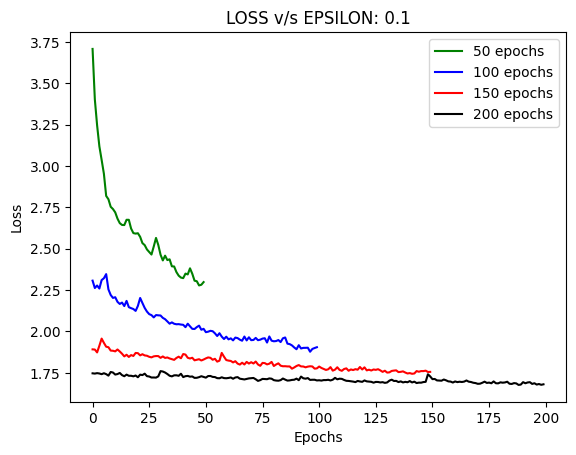

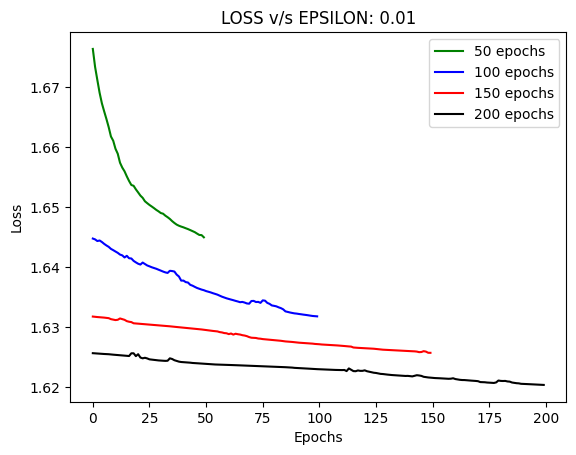

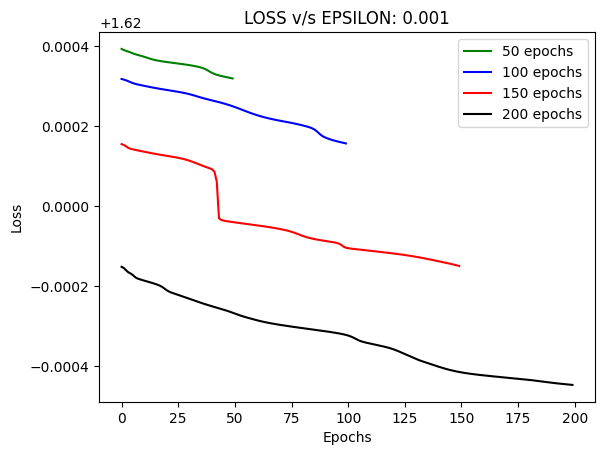

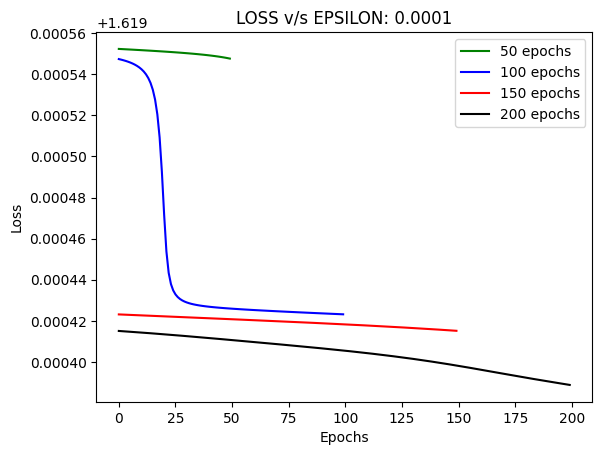

In [10]:
for j in [0.1, 0.01,0.001,0.0001]:
    plt.title("LOSS v/s EPSILON: {}".format(j))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    count = 0
    
    for combo in [('green', '50 epochs'), ('blue', '100 epochs'), ('red', '150 epochs'), ('black', '200 epochs')]:
        array = plot_dictionary['epsilon {}'.format(j)][count]
        x = np.arange(0, len(array) )
        y = array
        count += 1
        plt.plot(x, y, color=combo[0], label=combo[1])
        plt.legend()
    
    plt.show()